In [17]:
import pandas as pd 
import numpy as np
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb


# Feature set 1:
 tf-idf features

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Thesis data/train_clean',index_col=0 )
test_data = pd.read_csv('/content/drive/MyDrive/Thesis data/test_clean',index_col=0)

In [ ]:
train_data.head()

,product_uid,product_title,relevance,product_description,Brand,search_term_corrected,relevance_binary
0,100001,simpson strong tie 12 gaug angl,3.00,angl make joint stronger also provid consist s...,simpson strong tie,angl bracket,high
1,100001,simpson strong tie 12 gaug angl,2.50,angl make joint stronger also provid consist s...,simpson strong tie,l bracket,high
2,100002,behr premium textur deck 1 gallon sc 141 tugbo...,3.00,behr premium textur deckov innov solid color c...,behr premium textur deck,deck,high
3,100005,delta vero 1 handl shower faucet trim kit chro...,2.33,updat bathroom delta vero singl handl shower f...,delta,rain shower head,high
4,100005,delta vero 1 handl shower faucet trim kit chro...,2.67,updat bathroom delta vero singl handl shower f...,delta,shower faucet,high


    - Splitting train dataset : 80 - 20.

In [ ]:
y = train_data['relevance']
X = train_data.drop(['relevance','relevance_binary'],axis = 1)

In [ ]:
#splitting the train data into 80% train 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('X_train',X_train.shape)
print('X_test',X_test.shape)

X_train (59237, 5)
X_test (14810, 5)


In [ ]:
# search term vectorization
#considering only the top 1000 unigrams
tfidf_model_S = TfidfVectorizer(max_features=1000)
#fitting the tfidf vectorizer on search term
tfidf_model_S.fit(X_train['search_term_corrected'].astype('U'))
# getting the tfidf vectors for search
tfidf_S = tfidf_model_S.transform(X_train['search_term_corrected']) #train
tfidf_S_test = tfidf_model_S.transform(X_test['search_term_corrected']) #test

In [ ]:
# document vectorization
doc = X_train['product_title'].astype('U') + ' ' + X_train['product_description'].astype('U') + ' ' + X_train['Brand'].astype('U')
doc_test = X_test['product_title'].astype('U') + ' ' + X_test['product_description'].astype('U') + ' ' + X_test['Brand'].astype('U')
#considering only the top 1000 unigrams
tfidf_model_D = TfidfVectorizer(max_features=1000)
#fitting the tfidf vectorizer on doc
tfidf_model_D.fit(doc)
# getting the tfidf vectors for doc
tfidf_D = tfidf_model_D.transform(doc) #train
tfidf_D_test = tfidf_model_D.transform(doc_test) #test

In [ ]:
print('search term tfidf shapes:')
print('train data shape -',tfidf_S.shape)
print('test data shape -',tfidf_S_test.shape)
print('*'*100)

print('doc tfidf shapes:')
print('train data shape -',tfidf_D.shape)
print('test data shape -',tfidf_D_test.shape)


search term tfidf shapes:
train data shape - (59237, 1000)
test data shape - (14810, 1000)
****************************************************************************************************
doc tfidf shapes:
train data shape - (59237, 1000)
test data shape - (14810, 1000)


In [ ]:
#combining all the tf-idf features
train_1 = hstack((tfidf_S,tfidf_D)).tocsr()
test_1 = hstack((tfidf_S_test,tfidf_D_test)).tocsr()
print(train_1.shape)
print(test_1.shape)

(59237, 2000)
(14810, 2000)


1. Linear models: (Lasso, Ridge)

- Standardising the dataset.

In [ ]:
#Standardisation
scaler = StandardScaler(with_mean= False).fit(train_1)

X_train_std = scaler.transform(train_1)
X_test_std = scaler.transform(test_1)

1. 1 Linear regression + L1 (model 1)(Lasso)

In [ ]:
#Lasso
F1_1 = Lasso().fit(X_train_std,y_train)

#checking the rmse on test data
train_rmse_1 = mean_squared_error(y_train, F1_1.predict(X_train_std), squared=False)
test_rmse_1 = mean_squared_error(y_test, F1_1.predict(X_test_std), squared=False)
print ('train rmse :', train_rmse_1)
print ('test rmse :', test_rmse_1)

train rmse : 0.5338251612961014
test rmse : 0.5338602656330315


1. 2 Linear regression + L2 (model 2)

In [ ]:
#Ridge
F1_2 = Ridge().fit(X_train_std,y_train)

#checking the rmse on test data
train_rmse_2 = mean_squared_error(y_train, F1_2.predict(X_train_std), squared=False)
test_rmse_2 = mean_squared_error(y_test, F1_2.predict(X_test_std), squared=False)
print ('train rmse :', train_rmse_2)
print ('test rmse :', test_rmse_2)

train rmse : 0.4969591012388932
test rmse : 0.5186812249442627


1.3 XGBOOST:

In [ ]:
%%time
#Xgboost
F1_3 = XGBRegressor(objective = 'reg:squarederror').fit(train_1,y_train)
  
#checking the rmse on test data
train_rmse_3 = mean_squared_error(y_train, F1_3.predict(train_1), squared=False)
test_rmse_3 = mean_squared_error(y_test, F1_3.predict(test_1), squared=False)
print ('train rmse :', train_rmse_3)
print ('test rmse :', test_rmse_3)

train rmse : 0.5194938403127367
test rmse : 0.5258548903408254
CPU times: user 42.1 s, sys: 180 ms, total: 42.3 s
Wall time: 42.2 s


- Using the tf-idf vectorizer , the results are not that satisfactory.
-  This might be because both classes have similar unigrams and bigrams distribution.


#Feature set 2:
12 basic features + tfidf cosine features

In [15]:
train_2 = pd.read_csv('/content/drive/MyDrive/Thesis data/train_updated')
train_2.drop(['Unnamed: 0','relevance_binary'],axis = 1, inplace= True)
# test_0 = pd.read_csv('/content/drive/MyDrive/Thesis data/test_updated')
# test_0.drop(['Unnamed: 0','tfidf_cos_sim_S_T','tfidf_cos_sim_S_D'],axis = 1, inplace= True)
train_2.columns

Index(['relevance', 'len_search', 'len_desc', 'len_title', 'len_brand',
       'common_S_T', 'common_S_D', 'last_in_title', 'last_in_desc',
       'last_in_brand', 'ratio_title', 'ratio_desc', 'ratio_brand',
       'tfidf_cos_sim_S_T', 'tfidf_cos_sim_S_D'],
      dtype='object')

In [16]:
train_2.head()

,relevance,len_search,len_desc,len_title,len_brand,common_S_T,common_S_D,last_in_title,last_in_desc,last_in_brand,ratio_title,ratio_desc,ratio_brand,tfidf_cos_sim_S_T,tfidf_cos_sim_S_D
0,3.00,2,98,6,3,1,1,0,0,0,0.500000,0.500000,0.0,0.323711,0.219918
1,2.50,2,98,6,3,0,0,0,0,0,0.000000,0.000000,0.0,0.000000,0.000000
2,3.00,1,127,12,4,1,1,1,1,1,1.000000,1.000000,1.0,0.317344,0.244167
3,2.33,3,77,11,1,1,1,0,0,0,0.333333,0.333333,0.0,0.195644,0.067670
4,2.67,2,77,11,1,2,2,1,1,0,1.000000,1.000000,0.0,0.492489,0.170345


In [ ]:
print('shape of the train data', train_2.shape)

shape of the train data (74047, 15)


    - Splitting train dataset : 80 - 20.

In [ ]:
y = train_2['relevance']
X = train_2.drop('relevance',axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split
#splitting the train data into 80% train 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
print('X_train',X_train.shape)
print('X_test',X_test.shape)

X_train (59237, 14)
X_test (14810, 14)


- Standardising the dataset.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

1.2 Linear regression + L1 (model 1)(Lasso)

In [ ]:
#Lasso
model_1 = Lasso().fit(X_train_std,y_train)

#checking the rmse on test data
train_rmse_1 = mean_squared_error(y_train, model_1.predict(X_train_std), squared=False)
test_rmse_1 = mean_squared_error(y_test, model_1.predict(X_test_std), squared=False)
print ('train rmse :', train_rmse_1)
print ('test rmse :', test_rmse_1)

train rmse : 0.5338251612961014
test rmse : 0.5338602656330315


1. 2 Linear regression + L2 (model 2)

In [ ]:
#Ridge
model_2 = Ridge().fit(X_train_std,y_train)

#checking the rmse on test data
train_rmse_2 = mean_squared_error(y_train, model_2.predict(X_train_std), squared=False)
test_rmse_2 = mean_squared_error(y_test, model_2.predict(X_test_std), squared=False)
print ('train rmse :', train_rmse_2)
print ('test rmse :', test_rmse_2)

train rmse : 0.48860919894253335
test rmse : 0.489909082919918


1. 3  Linear regression + ElasticNet (model 3)

In [ ]:
#ElasticNet
model_3 = ElasticNet().fit(X_train_std,y_train)

#checking the rmse on test data
train_rmse_3 = mean_squared_error(y_train, model_3.predict(X_train_std), squared=False)
test_rmse_3 = mean_squared_error(y_test, model_3.predict(X_test_std), squared=False)
print ('train rmse :', train_rmse_3)
print ('test rmse :', test_rmse_3)

train rmse : 0.5338251612961014
test rmse : 0.5338602656330315


1. 4  Linear SVR (model 4)

In [ ]:
%%time
model_4 = SVR(kernel = 'linear').fit(X_train_std,y_train)

#checking the rmse on test data
train_rmse_4 = mean_squared_error(y_train, model_4.predict(X_train_std), squared=False)
test_rmse_4 = mean_squared_error(y_test, model_4.predict(X_test_std), squared=False)
print ('train rmse :', train_rmse_4)
print ('test rmse :', test_rmse_4)

train rmse : 0.4959853811683675
test rmse : 0.49738611404257427
CPU times: user 13min 10s, sys: 607 ms, total: 13min 11s
Wall time: 13min 8s


1. 5  Kernel SVR with rbf kernel (model 5)

In [ ]:
%%time
model_5 = SVR(kernel = 'rbf').fit(X_train_std,y_train)

#checking the rmse on test data
train_rmse_5 = mean_squared_error(y_train, model_5.predict(X_train_std), squared=False)
test_rmse_5 = mean_squared_error(y_test, model_5.predict(X_test_std), squared=False)
print ('train rmse :', train_rmse_5)
print ('test rmse :', test_rmse_5)

train rmse : 0.4754734952680981
test rmse : 0.4901721493760121
CPU times: user 11min 17s, sys: 509 ms, total: 11min 17s
Wall time: 11min 15s


1. 6  Decision Trees regressor (model 6)

In [ ]:

model_6 = DecisionTreeRegressor().fit(X_train,y_train) #using non standarised data here

#checking the rmse on test data
train_rmse_6 = mean_squared_error(y_train, model_6.predict(X_train), squared=False)
test_rmse_6 = mean_squared_error(y_test, model_6.predict(X_test), squared=False)
print ('train rmse :', train_rmse_6)
print ('test rmse :', test_rmse_6)

train rmse : 0.09267228482888319
test rmse : 0.6676287507656211


1. 7  Random forest (model 7)

In [ ]:
%%time

model_7 = RandomForestRegressor().fit(X_train,y_train) #using non standarised data here

#checking the rmse on test data
train_rmse_7 = mean_squared_error(y_train, model_7.predict(X_train), squared=False)
test_rmse_7 = mean_squared_error(y_test, model_7.predict(X_test), squared=False)
print ('train rmse :', train_rmse_7)
print ('test rmse :', test_rmse_7)

train rmse : 0.19979263799786026
test rmse : 0.4927473377659281
CPU times: user 35.8 s, sys: 49.9 ms, total: 35.8 s
Wall time: 35.8 s


1.8 GBDT (model 8)

In [ ]:
%%time
model_8 = GradientBoostingRegressor().fit(X_train,y_train) #using non standarised data here

#checking the rmse on test data
train_rmse_8 = mean_squared_error(y_train, model_8.predict(X_train), squared=False)
test_rmse_8 = mean_squared_error(y_test, model_8.predict(X_test), squared=False)
print ('train rmse :', train_rmse_8)
print ('test rmse :', test_rmse_8)

train rmse : 0.47901061126381345
test rmse : 0.4821776012533845
CPU times: user 9.66 s, sys: 23.9 ms, total: 9.68 s
Wall time: 9.67 s


1.9 Xgboost (model 9)

In [ ]:
%%time

model_9 = XGBRegressor(objective = 'reg:squarederror').fit(X_train,y_train)
  
#checking the rmse on test data
train_rmse_9 = mean_squared_error(y_train, model_9.predict(X_train), squared=False)
test_rmse_9 = mean_squared_error(y_test, model_9.predict(X_test), squared=False)
print ('train rmse :', train_rmse_9)
print ('test rmse :', test_rmse_9)

train rmse : 0.478980201238703
test rmse : 0.48221916059637404
CPU times: user 3.93 s, sys: 15 ms, total: 3.94 s
Wall time: 3.93 s




---


In [ ]:
#summary
model_perf = {'model' : ['Lasso','Ridge','ElasticNet','Linear SVR','SVR with rbf kernel','Decision Trees','Random Forest','GBDT','Xgboost'],'Train RMSE':[train_rmse_1,train_rmse_2,train_rmse_3,train_rmse_4,train_rmse_5,train_rmse_6,train_rmse_7,train_rmse_8,train_rmse_9],'Test RMSE':[test_rmse_1,test_rmse_2,test_rmse_3,test_rmse_4,test_rmse_5,test_rmse_6,test_rmse_7,test_rmse_8,test_rmse_9]}
pd.DataFrame(model_perf)

,model,Train RMSE,Test RMSE
0,Lasso,0.533825,0.533860
1,Ridge,0.488609,0.489909
2,ElasticNet,0.533825,0.533860
3,Linear SVR,0.495985,0.497386
4,SVR with rbf kernel,0.475473,0.490172
5,Decision Trees,0.092672,0.667629
6,Random Forest,0.199793,0.492747
7,GBDT,0.479011,0.482178
8,Xgboost,0.478980,0.482219


    So, the best rmse that we are getting is around 0.482

#Hyperparameter Tuning Xgboost model:

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)

def tuning(params,dtrain = dtrain):
    cv_results = xgb.cv( params,
    dtrain,
    num_boost_round=2000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=30,
    verbose_eval = 100)
    return cv_results

In [ ]:
params = {
    'max_depth':5,
    'min_child_weight': 50,
    'eta': 0.01,
    'subsample': 1,
    'colsample_bytree': 0.8,
    'objective':'reg:squarederror',
}


 max_depth,min_child_weight

In [ ]:

depth = [i for i in range(5,12)] ; min_child_weight =[i for i in range(50,300,50)]
l = None; par = None
for d in depth:
    #updating the max_depth
    params['max_depth'] = d
    for w in min_child_weight:
        #updating the min child weight
        print('max_depth = {} and min_child_weight = {}'.format(d,w))
        params['min_child_weight'] = w
        result = tuning(params)
        if l!=None:
            if result['test-rmse-mean'].min() < l:
                l = result['test-rmse-mean'].min()
                par = (d,w)
        else:
            l = result['test-rmse-mean'].min()
            par = (d,w)

#best parameters
print('best parameters (max_depth,min_child_weight) = {}'.format(par))
print('CV RMSE :', l)
        



max_depth = 5 and min_child_weight = 50
[0]	train-rmse:1.93775+0.000770178	test-rmse:1.93778+0.00307737
[100]	train-rmse:0.840299+0.000499782	test-rmse:0.840983+0.00419396
[200]	train-rmse:0.542579+0.000608253	test-rmse:0.544628+0.00373375
[300]	train-rmse:0.487087+0.000650123	test-rmse:0.490487+0.00297405
[400]	train-rmse:0.477648+0.000652806	test-rmse:0.482186+0.00257811
[500]	train-rmse:0.47526+0.000603174	test-rmse:0.480786+0.00245454
[600]	train-rmse:0.474128+0.000547264	test-rmse:0.480516+0.00242129
[700]	train-rmse:0.473295+0.000550102	test-rmse:0.480412+0.00241742
[800]	train-rmse:0.472576+0.000609152	test-rmse:0.480356+0.00240645
[900]	train-rmse:0.471914+0.000634966	test-rmse:0.48032+0.0024385
[1000]	train-rmse:0.471291+0.000651105	test-rmse:0.480306+0.00246023
[1100]	train-rmse:0.470674+0.000664586	test-rmse:0.480279+0.00246813
max_depth = 5 and min_child_weight = 100
[0]	train-rmse:1.93775+0.000769702	test-rmse:1.93778+0.00307717
[100]	train-rmse:0.840351+0.000488689	test-r

In [ ]:
params['max_depth'] = 11
params['min_child_weight'] = 50
params['eta'] = 0.01
params

{'colsample_bytree': 0.8,
 'eta': 0.01,
 'max_depth': 11,
 'min_child_weight': 50,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [ ]:
tuning(params)

[0]	train-rmse:1.93773+0.000770624	test-rmse:1.93778+0.00307645
[100]	train-rmse:0.83626+0.000516764	test-rmse:0.840486+0.00419157
[200]	train-rmse:0.527245+0.000592233	test-rmse:0.542826+0.00386395
[300]	train-rmse:0.46393+0.000800972	test-rmse:0.48845+0.00315044
[400]	train-rmse:0.450945+0.000870828	test-rmse:0.480585+0.00284803
[500]	train-rmse:0.446505+0.000918244	test-rmse:0.479582+0.00272093
[600]	train-rmse:0.443928+0.00107559	test-rmse:0.479468+0.00272222


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.937733,0.000771,1.937778,0.003076
1,1.919606,0.000747,1.919634,0.003088
2,1.901666,0.000733,1.901688,0.003114
3,1.883909,0.000737,1.883937,0.003132
4,1.866307,0.000745,1.866373,0.003143
...,...,...,...,...
587,0.444244,0.001049,0.479465,0.002717
588,0.444218,0.001051,0.479464,0.002716
589,0.444189,0.001047,0.479462,0.002713
590,0.444172,0.001051,0.479462,0.002713


colsample_bytree, subsample

In [ ]:
colsam = [0.5,0.8]
subsam = [0.5,0.8,1]

l = None; par = None
for c in colsam:
    #updating the colsample_bytree
    params['colsample_bytree'] = c
    for s in subsam:
        #updating the subsample
        print('colsample_bytree = {} and subsample = {}'.format(c,s))
        params['subsample'] = s
        result = tuning(params)
        if l!=None:
            if result['test-rmse-mean'].min() < l:
                l = result['test-rmse-mean'].min()
                par = (c,s)
        else:
            l = result['test-rmse-mean'].min()
            par = (c,s)

#best parameters
print('best parameters (colsample_bytree,subsample) = {}'.format(par))
print('CV RMSE :', l)



colsample_bytree = 0.5 and subsample = 0.5
[0]	train-rmse:1.93779+0.000766432	test-rmse:1.93783+0.00308555
[100]	train-rmse:0.840208+0.000532248	test-rmse:0.842005+0.00407718
[200]	train-rmse:0.536371+0.000616583	test-rmse:0.544255+0.00370834
[300]	train-rmse:0.475583+0.000666949	test-rmse:0.489242+0.00299429
[400]	train-rmse:0.462867+0.000696694	test-rmse:0.480951+0.00265174
[500]	train-rmse:0.45808+0.000654451	test-rmse:0.479663+0.00254457
[600]	train-rmse:0.45478+0.000599061	test-rmse:0.479478+0.00247502
colsample_bytree = 0.5 and subsample = 0.8
[0]	train-rmse:1.93779+0.000758748	test-rmse:1.93782+0.0030827
[100]	train-rmse:0.839051+0.000569308	test-rmse:0.841523+0.00406085
[200]	train-rmse:0.532958+0.000667966	test-rmse:0.543632+0.00368077
[300]	train-rmse:0.470527+0.000662657	test-rmse:0.488744+0.00302201
[400]	train-rmse:0.456842+0.000675721	test-rmse:0.480543+0.0026744
[500]	train-rmse:0.451564+0.000677359	test-rmse:0.479303+0.00253368
[600]	train-rmse:0.448194+0.000644794	test

In [ ]:
params['colsample_bytree'] = 0.5
params['subsample'] = 0.8
params

{'colsample_bytree': 0.5,
 'eta': 0.01,
 'max_depth': 11,
 'min_child_weight': 50,
 'objective': 'reg:squarederror',
 'subsample': 0.8}

In [ ]:
tuning(params)

[0]	train-rmse:1.93779+0.000758748	test-rmse:1.93782+0.0030827
[100]	train-rmse:0.839051+0.000569308	test-rmse:0.841523+0.00406085
[200]	train-rmse:0.532958+0.000667966	test-rmse:0.543632+0.00368077
[300]	train-rmse:0.470527+0.000662657	test-rmse:0.488744+0.00302201
[400]	train-rmse:0.456842+0.000675721	test-rmse:0.480543+0.0026744
[500]	train-rmse:0.451564+0.000677359	test-rmse:0.479303+0.00253368
[600]	train-rmse:0.448194+0.000644794	test-rmse:0.479108+0.00253059


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.937785,0.000759,1.937819,0.003083
1,1.919661,0.000762,1.919689,0.003087
2,1.901732,0.000743,1.901743,0.003108
3,1.884016,0.000741,1.884038,0.003125
4,1.866457,0.000739,1.866503,0.003149
...,...,...,...,...
642,0.446999,0.000643,0.479085,0.002529
643,0.446976,0.000645,0.479083,0.002530
644,0.446951,0.000647,0.479082,0.002531
645,0.446928,0.000641,0.479083,0.002532


#Final Model with best parameters on test set:

In [ ]:
dtest = xgb.DMatrix(X_test, label= y_test)

f_model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval = 100
)

[0]	Test-rmse:1.93781
Will train until Test-rmse hasn't improved in 10 rounds.
[100]	Test-rmse:0.841205
[200]	Test-rmse:0.543594
[300]	Test-rmse:0.488883
[400]	Test-rmse:0.480542
[500]	Test-rmse:0.479298
Stopping. Best iteration:
[571]	Test-rmse:0.479064



- Retraining the model with best parameters with random state 42.

In [ ]:
#splitting the train data into 80% train 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y,random_state= 42)
print('X_train',X_train.shape)
print('X_test',X_test.shape)

X_train (59237, 14)
X_test (14810, 14)


In [ ]:
dtrain = xgb.DMatrix(X_train, label= y_train)

dtest = xgb.DMatrix(X_test, label= y_test)

best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtest, "Test")],
    early_stopping_rounds = 10,
    verbose_eval = 100)


[0]	Test-rmse:1.93779
Will train until Test-rmse hasn't improved in 10 rounds.
[100]	Test-rmse:0.841
[200]	Test-rmse:0.543162
[300]	Test-rmse:0.488052
[400]	Test-rmse:0.479676
[500]	Test-rmse:0.478452
Stopping. Best iteration:
[568]	Test-rmse:0.478251



In [ ]:
# not applying early stopping since we already know the exact num_rounds
num_boost_round = best_model.best_iteration + 1
best_final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    verbose_eval = 100)

[0]	Test-rmse:1.93779
[100]	Test-rmse:0.841
[200]	Test-rmse:0.543162
[300]	Test-rmse:0.488052
[400]	Test-rmse:0.479676
[500]	Test-rmse:0.478452
[568]	Test-rmse:0.478251


- Cross-checking if the final RMSE score by using the predictions of the best model is same as what we got in the last round.

In [ ]:
best_test_rmse = mean_squared_error(y_test, best_final_model.predict(dtest), squared=False)
print ('Best test rmse :', best_test_rmse)

Best test rmse : 0.47825128094477554


#Saving the best model

In [ ]:
# best_final_model.save_model("/content/drive/MyDrive/Thesis data/models/model1.model")

In [7]:

model1 = xgb.Booster()
model1.load_model("/content/drive/MyDrive/Thesis data/models/model1.model")

In [8]:
train_2 = pd.read_csv('/content/drive/MyDrive/Thesis data/train_updated')
train_2.drop(['Unnamed: 0','relevance_binary'],axis = 1, inplace= True)
# test_0 = pd.read_csv('/content/drive/MyDrive/Thesis data/test_updated')
# test_0.drop(['Unnamed: 0'],axis = 1, inplace= True)

y = train_2['relevance']
X = train_2.drop('relevance',axis = 1)


In [9]:
#splitting the train data into 80% train 20% test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y,random_state= 42)
print('X_train',X_train.shape)
print('X_test',X_test.shape)

X_train (59237, 14)
X_test (14810, 14)


In [10]:
dtrain = xgb.DMatrix(X_train, label= y_train)
dtest = xgb.DMatrix(X_test, label= y_test)

print('train RMSE:',mean_squared_error(y_train, model1.predict(dtrain), squared=False))
print('test RMSE:',mean_squared_error(y_test, model1.predict(dtest), squared=False))


train RMSE: 0.4509890705696461
test RMSE: 0.47825128509503684


##Feature Importances:

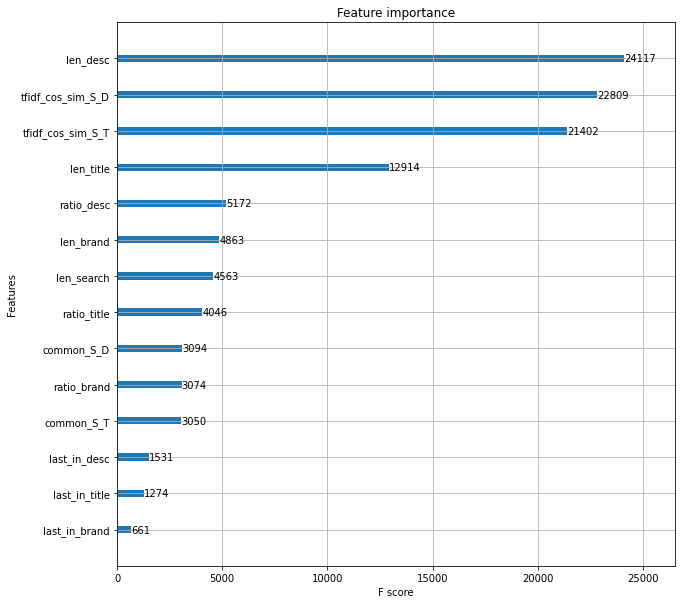

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model1, ax=ax)